# K-means clustering

## Learning objectives
- implement K-means clustering from scratch

## Intro - unsupervised clustering

So far we have only discussed the supervised learning case. In general:
- Supervised learning is where our dataset includes labels.
- Unsupervised learning is where our dataset does not include labels

In the latter case, the goal is to uncover some underlying structure of the data and that's what K-Means does.

### What is clustering?

One way to characterise some structure in the data would be to group together different examples into clusters, this is known as **clustering**.

## The K-means clustering algorithm 

K-means clustering is one of the simplest clustering algorithms. For it's basic version we should follow these steps:
- initialise `K` random points (taken from our data) called centroids
- assign every example to centroid based on distance (creating cluster)
- update centroids by taking mean of features of each cluster
- repeat until centroids do not move (all points are assigned to the same cluster each time)

### Visualization

Below you can see how the process looks on [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data treated with [PCA](https://drscotthawley.github.io/blog/2019/12/21/PCA-From-Scratch.html) dimensionality reduction algorithm.

![](images/kmeans.gif)

Given above let's implement it from scratch!

# K Means

## Distance

We will start with distance implementation (euclidean distance precisely). Using `numpy` and it's vectorization power it is only one line!

Our `KMeans` will have an option to pass this distance function during construction.

In [3]:
class DistanceFromExamples:
    def __init__(self, X):
        self.X = X

    def __call__(self, c):
        return np.linalg.norm(self.X - c, axis=1)

We will later use Python's `multiprocessing` so the cluster calculations will run in parallel. `DistanceFromExamples` has to be serializable object in order for us to use `multiprocessing.

## Importance of initialization

In K-Means initialization is key, let's see why is that a case with random data created with `make_blobs`:

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

sns.set_style('white')

# 300 samples
data, _ = make_blobs(n_samples=300, centers=6,
                       cluster_std=0.5, random_state=0)
data = pd.DataFrame(data=data, columns=["X1", "X2"])

Now let's see what is the difference between:
- random initialization (take any random point from our samples and make it a centroid)
- k-means++ initialization

K-Means++ below which "intuitively" does what we want

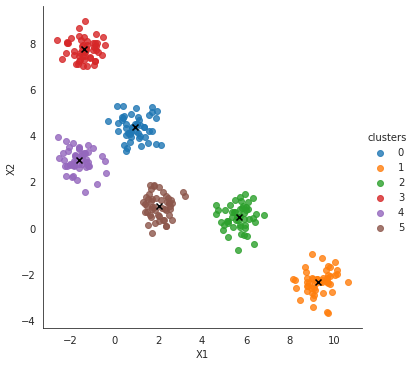

In [6]:
def plot_clusters_and_centroids(k_means, data):
    data['clusters'] = k_means.fit_predict(data)

    centroids = k_means.cluster_centers_ 
    sns.lmplot(x='X1', y='X2', hue='clusters', data=data, fit_reg=False)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker="x")
    data.drop("clusters", axis="columns", inplace=True)

plot_clusters_and_centroids(KMeans(n_clusters=6, n_init=1), data)

It might not be that pretty for `random` initialization though (you might have to run this snippet a few times):

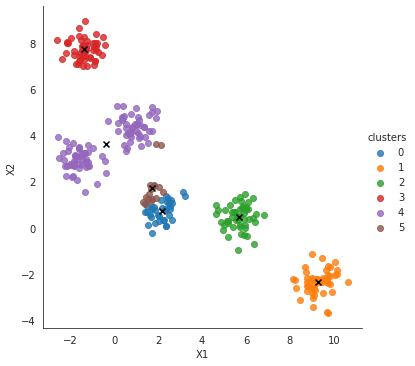

In [8]:
plot_clusters_and_centroids(KMeans(n_clusters=6, init="random", n_init=1), data)

### What happened?

- Random initialization takes any point as initial cluster. __It might be the case that two centroids are close to each other__. In such case centroid won't be able to move significantly as it is blocked by another cluster. Or it might have too much examples as there are no centroids nearby to "take them" from it.
- K-Means++ initialization scheme mitigates this problem via simple algorithm

## K-Means++ init

That's how it looks:
1. Decide how many clusters we need (`K`)
2. Take random sample from data as initial centroid
3. Calculate distance __of each sample__ to __EVERY PREVIOUS centroid__
4. Take __smallest__ distance __of each sample__ to __any cluster__
5. The further awawy the sample is the higher the chance for it to be taken as next
centroid
6. Get new centroid based on weighted probability from `5`
7. Repeat steps 3-7 until we get `K` centroids

In [16]:
# Double check

def k_means_plus_plus(X, n_clusters: int):
    # Choose random data point as an initial centroid
    first_centroid_index = np.random.randint(0, X.shape[0])
    centroids = [X[first_centroid_index]]
    
    # Initialize matrix keeping distances of each point from each centroid
    squared_distances = np.empty((n_clusters, X.shape[0]))

    # Iterate over all centroids to be found (except the first one)
    for i in range(n_clusters - 1):
        # Calculate distance between last cluster and all points
        squared_distances[i] = np.linalg.norm(centroids[-1] - X, axis=1) ** 2
        minimal_squared_distances = np.min(squared_distances[:i+1], axis=0)
        # Create weighted probability distribution
        probabilities = minimal_squared_distances / np.sum(minimal_squared_distances)

        # Randomly select new centroid based on weighted probability array
        centroid_index = np.random.choice(len(probabilities), p=probabilities)

        # Add new centroid to centroids list
        centroids.append(X[centroid_index])

    return np.array(centroids)

`sklearn`'s `kmeans` allows for custom initialization of centroids so we can test how our methods works right away. Black squares are initial centroid points, black crosses are centroids calculated finally.

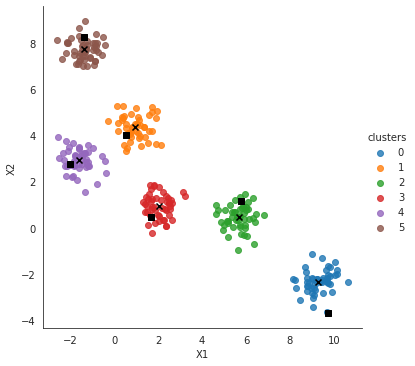

In [24]:
centroids = k_means_plus_plus(data.values, 6)
plot_clusters_and_centroids(KMeans(n_clusters=6, init=centroids, n_init=1), data)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker="s")

## K-Means

Now, given we have correct initialization scheme we can get to `K-Means` implementation:

In [26]:
import typing


class KMeans:
    def __init__(
        self,
        *,
        n_clusters: int = 8,
        initialization=None,
        tolerance: int = 1e-4,
        max_iterations: int = 300,
        n_jobs: int = None,
        distance: typing.Callable[[np.array], np.array] = DistanceFromExamples
    ):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        # If change negligible end algorithm
        self.tolerance = tolerance
        # One of random or k-means-plus-plus
        if initialization is None:
            self.initialization = k_means_plus_plus
        elif initialization == "random":
            self.initialization = lambda X: X[
                np.random.randint(0, X.shape[0], size=n_clusters)
            ]
        else:
            raise ValueError("initialization parameter has to be callable or 'random'")
        if n_jobs is not None:
            # Use as many jobs as specified or as many as clusters
            self.n_jobs = n_jobs if n_jobs <= n_clusters else n_clusters
        else:
            self.n_jobs = 1
        # Initial clusters will be created using our data
        self.centroids_ = None

    def fit(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        self.centroids_ = self.initialization(X)

        with multiprocessing.Pool(processes=self.n_jobs) as pool:
            for _ in range(self.max_iterations):
                # Calculate distance from cluster for each data point
                distances_from_clusters = np.array(
                    pool.map(self.distance(X), self.cluster_centers)
                )

                # Assign each data point to cluster based on minimum distance
                examples_clustered = np.argmin(distances_from_clusters, axis=0)
                # Create masks separating datapoints into clusters
                clusters_masks = np.array(
                    [
                        examples_clustered == cluster
                        for cluster in range(self.n_clusters)
                    ]
                )

                new_cluster_centers = np.array(
                    [np.mean(X[mask], axis=0) for mask in clusters_masks]
                )

                # If centroids didn't move end algorithm
                iteration_distance = np.linalg.norm(
                    self.cluster_centers - new_cluster_centers
                )
                if iteration_distance < self.tolerance:
                    return self
                self.cluster_centers = new_cluster_centers
        return self

    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        with multiprocessing.Pool(process=self.n_jobs) as pool:
            distances_from_clusters = np.array(
                pool.map(self.distance(X), self.cluster_centers)
            )
            return np.argmin(distances_from_clusters, axis=0)

    def fit_predict(self, X):
        self.fit(X)
        return self.fit(X).predict(X)

## Limitations of the algorithm
- if one centroid is never the closest one to any datapoint, then it will not be updated, and will represent a random point in space
    - this may not be obvious if the data is too high dimensional to visualise
- in the unsupervised case, it may not be obvious what the best K to use.
    - however, it can also be an advantage if you plan to use the output clusters as inputs to further processing
        - e.g. for image processing, K-means can be used to monochrome an image, before processing that image.
- K-means doesn't always provide the same results because the centroids are placed randomly to start with.
- as the number of dimensions of each example's features increases, the distance between any pairs of datapoints tends to a constant value, which makes the algorithm less effective as examples become harder to distinguish. This is the curse of dimensionality at work. See more [here](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages)
- K-means clustering is not capable of clustering groups of data that are not blob shaped. This is because some of the K-nearest points may not be part of the same cluster. See the graph below, where K-means clustering fails to correctly cluster the datapoints to what you'd expect.

![](images/kmeans_fails.png)

See what happens when we use `moons` dataset and K-Means:

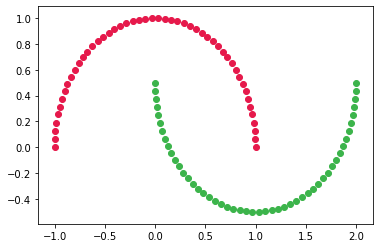

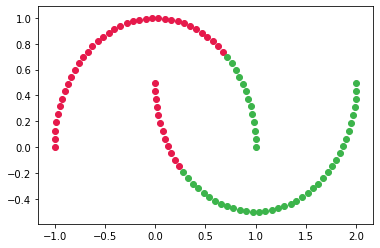

In [18]:
import sklearn.datasets
from sklearn.cluster import KMeans  # # import kmeans model from sklearn

moonsX, moonsY = sklearn.datasets.make_moons()
show_data(moonsX, moonsY)

kmeans = KMeans(n_clusters=2) ## init k means with a given number of centroids
kmeans.fit(moonsX, moonsY) ## fit
predictions = kmeans.predict(moonsX) ## make predictions
show_data(moonsX, predictions)

## Challenges

- What happens when we use `max` distance instead of weighted probability distribution in K-Means++? Change the code and see for yourself

## Summary

- K-Means is an unsupervised machine learning algorithm
- K-Means clusters similar data based on distance metrics
- __Centroids__ are centers of the cluster (and don't have to be an example)
- __Initialization is key__ hence it is almost always be worthy to run K-Means multiple times and use `K-Means++` initialization scheme instead of naive approach
- __Centroids are moved until convergence__ and are calculated as mean position of all examples in the clusters currnetly